In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np 
import pandas as pd

kmax = 500
lamb = 0.3
rho = 1/4
vax_rate = .40

I0 = 0.001 #initial fraction of infected nodes

# Initial conditions
prob = 1/4

pk_arr = np.array([prob*(1-prob)**k for k in range(1, kmax + 1)]) ## probability for each k
pk_arr = pk_arr/sum(pk_arr)

vax_pk = pk_arr*(vax_rate)
unvax_pk = pk_arr*(1-vax_rate)

IVk = vax_pk*(I0) ## initial condition for infected vaccinated
IUk = unvax_pk*(I0) ## initial condnition for infectedu unvaccinated



full_initial_c = np.concatenate([IVk, IUk]) ## all initial conditions together (to prepare for integator)

In [2]:
def decompose_full_arr(arr, kmax):
    IVk = arr[0:kmax]
    IUk = arr[kmax:(kmax*2)]

    return IVk, IUk

def SIS_net(w, t, p):
    ## initial followed this example to build this model https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html
    lamb, vax_rate, rho, kmax, prob, vax_pk, unvax_pk = p

    ks = np.arange(1, kmax+1)
    pk = np.array([prob*(1-prob)**k for k in range(1, kmax + 1)])
    pk = pk/sum(pk)
    
    IVk, IUk = decompose_full_arr(w, kmax)

    theta = ((1-rho)*sum(IVk*ks) + sum(IUk*ks))/sum(ks*pk)

    IVk_dt = lamb*theta*ks*(1-rho)*(vax_pk - IVk) - IVk
    IUk_dt = lamb*theta*ks*(unvax_pk - IUk) - IUk

    full_status = np.concatenate([IVk_dt, IUk_dt])
    
    return full_status

def run_integrator(initial_I, rho, prob, vax_pk, unvax_pk, numpoints, stoptime = 10.0, abserr = 1.0e-8, relerr = 1.0e-6):
    p = [lamb, vax_rate, rho, kmax, prob, vax_pk, unvax_pk]
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    wsol = odeint(SIS_net, initial_I, t, args=(p,))
    result_list =  [tuple(decompose_full_arr(ts, kmax)) for ts in (wsol.tolist())]
    infected_ts = [sum(obs[0]) + sum(obs[1]) for obs in result_list]
    return pd.DataFrame.from_dict({"rho": rho, "ts": np.arange(0, numpoints),  "infected": infected_ts})


In [3]:
rho_test = np.arange(.05, 1, .05)
rho_simulation_result = [run_integrator(full_initial_c, rho, prob, vax_pk, unvax_pk,5000) for rho in rho_test  ]
rho_result_pd = pd.concat(rho_simulation_result)

In [4]:
rho_result_pd.query("infected < .0001").sort_values(["rho", "ts"]) ## first moment and lowest rho where infected breaches threshold

,rho,ts,infected


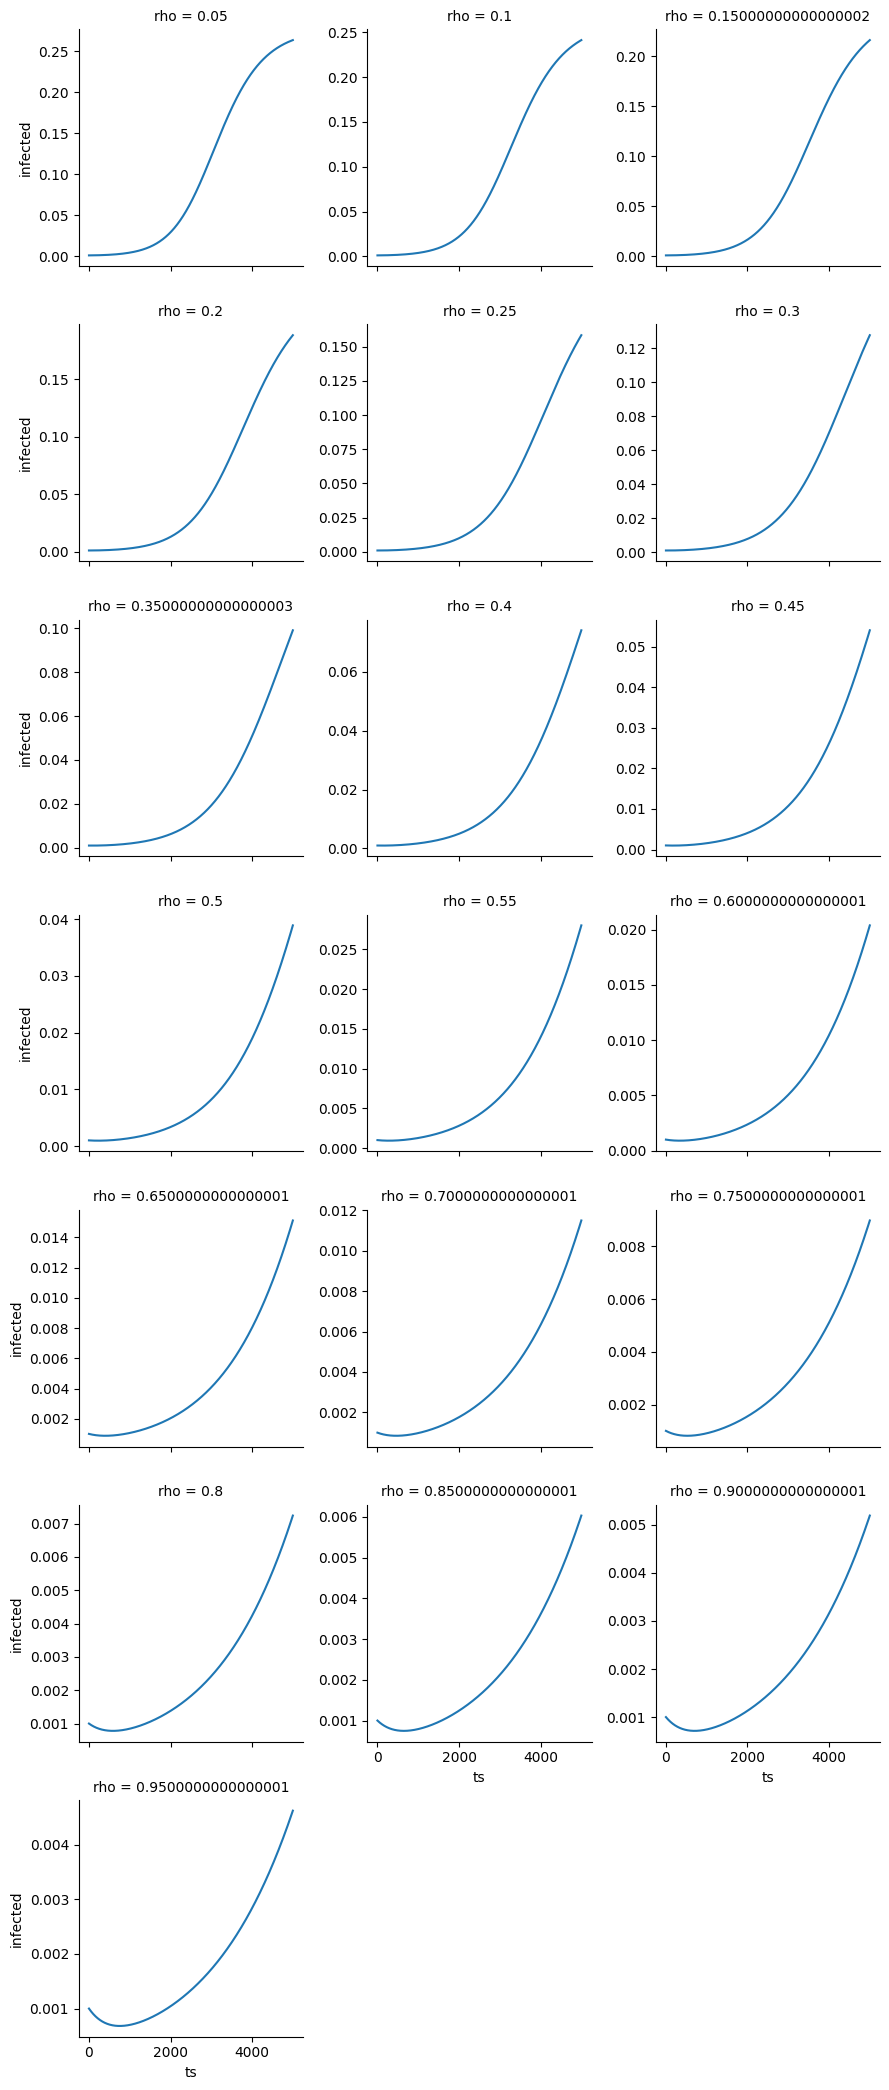

In [5]:
import seaborn as sns

g = sns.FacetGrid(rho_result_pd, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected")

g.savefig("03/output/c_infection_curve.png")


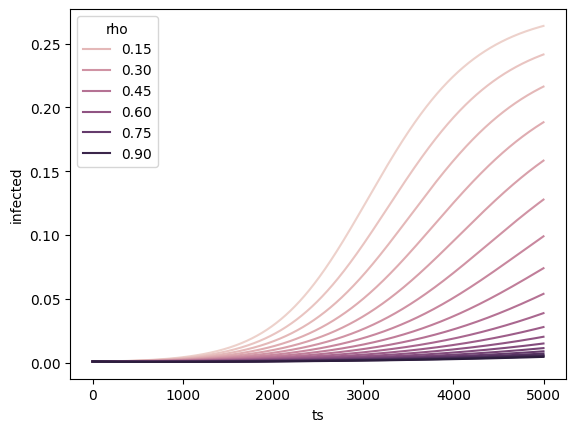

In [6]:
# plot again, but all graphs in the same plot
c_all = sns.lineplot(data = rho_result_pd, x = "ts", y = "infected", hue = "rho")

fig = c_all.get_figure()
fig.savefig("03/output/c_infection_curve_all.png")

In [7]:
pk_arr_cs = np.cumsum(pk_arr)

first_60 = np.min(np.where(pk_arr_cs > .60))

vax_d_pk = np.zeros(kmax)
vax_d_pk[first_60:kmax] = pk_arr[first_60:kmax]

unvax_d_pk = np.zeros(kmax)
unvax_d_pk[0:first_60] = pk_arr[0:first_60]

IVk_d = vax_d_pk*(I0) 
IUk_d = unvax_d_pk*(I0)

full_initial_d = np.concatenate([IVk_d, IUk_d])

In [8]:
rho_simulation_result_d = [run_integrator(full_initial_d, rho, prob, vax_d_pk, unvax_d_pk, 5000) for rho in rho_test  ]
rho_result_d_pd = pd.concat(rho_simulation_result_d)

In [9]:
rho_result_d_pd["part"] = "d"
rho_result_pd["part"] = "c"
all_rho_results = pd.concat([rho_result_d_pd, rho_result_pd])

In [10]:
all_rho_results.query("infected < .0001 and part == 'd'").sort_values(["rho", "ts"]) ## first moment where part d breaches threshold (lowest rho)

,rho,ts,infected,part
3975,0.45,3975,9.995502e-05,d
3976,0.45,3976,9.990561e-05,d
3977,0.45,3977,9.985623e-05,d
3978,0.45,3978,9.980688e-05,d
3979,0.45,3979,9.975755e-05,d
...,...,...,...,...
4995,0.95,4995,1.740488e-07,d
4996,0.95,4996,1.737420e-07,d
4997,0.95,4997,1.734358e-07,d
4998,0.95,4998,1.731302e-07,d


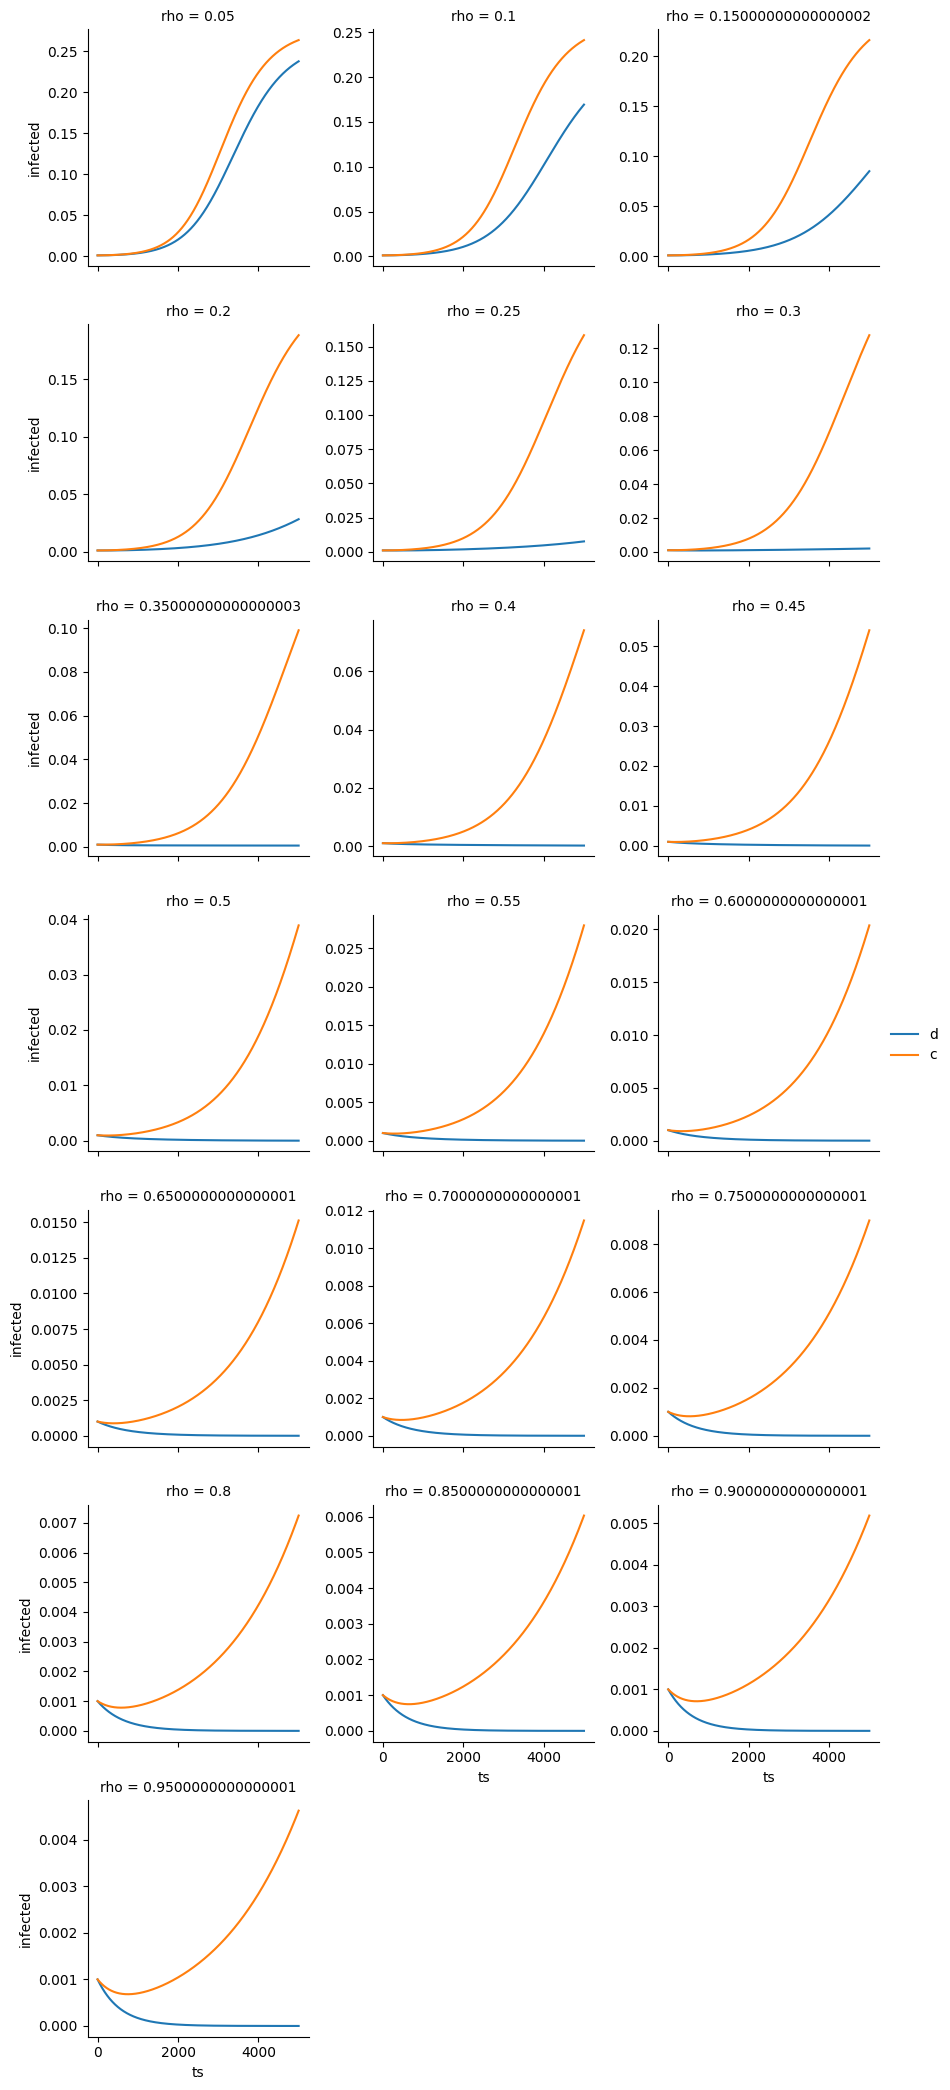

In [11]:
g = sns.FacetGrid(all_rho_results, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected", hue = "part")
g.add_legend()

g.savefig("03/output/c_d_infection_curve.png")


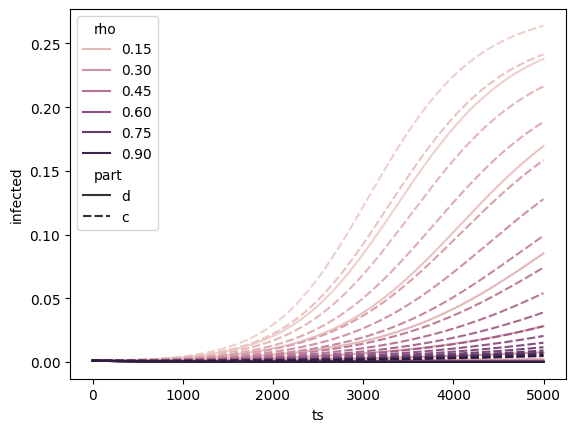

In [12]:

# plot again but all graphs in one plot
c_d_all = sns.lineplot(data = all_rho_results, x = "ts", y = "infected", hue = "rho", style = "part")

fig = c_d_all.get_figure()
fig.savefig("03/output/c_d_infection_curve_all.png")